# Project
This project is for Machine Learning course in Bogazici University(CMPE462).

The objective of the project is to extract some features from a data set and apply linear regression methods to this data set in order to fit the predictions to test data as much as possible. 

The challenge for the project is to decide which features to extract from data set and how to manipulate them, namely "feature engineering".

See **Approaches** section for the ways we have tried to find the best solution.
See **Evaluation** section for the final solution.
See **Data Analysis & Visualization** section for constructing best feature.

# Approaches

## 1. Single Feature
We started off with applying linear regression by using each numerical feature(Age, Foreign, Multinational, Market Value) one by one and analyzing predictions. We used the data for year 2015 as test data and the remaining as train data from the given data set. However, we cannot get a good result from single feature.

The table below shows some of the results when the data of an entire year(2013, 2014 or 2015) is selected as test data and the remaining are train data. Results change in each row as aggregation function changes. Kendall Tau values are out of 100.

|Aggregation                                    | 2013  | 2014  | 2015  | Mean | STD  |
|:---:                                          | :---: | :---: | :---: | :---:|:---: |
|`market(mean)`                                 | 45.18 | 40.40 | 38.03 | 41.20| 2.97 |
|`market(sum)`                                  | 39.87 | 29.80 | 28.85 | 32.84| 4.98 |
|`age(mean)`                                    | 9.30  | 16.55 | 45.90 | 23.91| 15.82|
|`age(sum)`                                     |-15.94 |-40.40 |-31.47 |-29.27| 10.10|
|`age(max)`                                     |-26.58 |-20.53 |-20.98 |-22.69| 2.75 |

## 2. Multiple Features
The table below shows the result when the data of an entire year(2013, 2014 or 2015) is selected as test data and the remaining are train data. Results change in each row as aggregation function changes. Kendall Tau values are out of 100.

Here are the reasons behind our approaches:

* **Taking logarithm of market value**: We used weighted average of market value and age in example 4. Since market values are large number compared to ages, we had to scale them. In order to do so, we took the logarithm of market value.
* **Median of ages**: In many cases, what primarily determines the points of a football team is the performance of the majority of the team, not the average of it. For example, a team's most successful and frequent players may be young and there might be a couple of elder footballers in the team. Then, number of points will be mainly determined by these young players. So, mean of ages would be misleading in this case since a couple of elder and unimportant players affect this value.
* **Sum of ages/market values of most valuable players in the team**: Even a better approach while taking ages into account would be only considering the most valuable 11 players. This makes sense if we assume that a football team's most frequent players are probably the most valuable ones.
* **Sum of market values of least valuable players in the team**: Least valuable players are also important factors which might decrease the points of a team.
* **Number of foreigners which are among the most valuable players in their team**: We might conclude that if a team’s most valuable players are mostly foreign, then this team has higher points. We selected most valuable 15 players in order to take substitute players into account.
* **Count of German players**: When we sort nationalities according to their mean of market values, we observed that highest ranked teams in the train data contain German players. Thus, we can expect German players to increase the points of a team. Actually, Turkish players are more than German players in successful teams. However, Turkish players do not affect the points as much as Germans do. 

|Index|Aggregation                                    | 2013  | 2014  | 2015  | Mean | STD |
|:---:|:---:                                          | :---: | :---: | :---: | :---:|:---:|
|1|```age(mean), age(median), age(market(sum of largest 11 players)), market(sum of largest 11 players), market(mean), market(sum of smallest 3 players), player(count), foreign(market(sum of largest 15 players)), nationality(count of Germany)```                                     | 61.13 | 60.27 | 64.26 | 61.88| 2.09|
|2|`market(sum), age(mean), multinational(count)` | 63.79 | 49.67 | 56.39 | 56.61| 7.06|
|3|`market(mean), age(mean), multinational(count)`| 63.79 | 50.99 | 53.77 | 56.18| 6.73|
|4|`log(market(mean))*0.6 + age(mean)*0.4`        | 46.51 | 36.42 | 69.50 | 50.81|16.95|
|5|`market(mean), age(mean)`                      | 49.17 | 45.69 | 52.45 | 49.10| 3.38|
|6|`market(mean), age(mean), foreign(mean)`       | 46.51 | 43.05 | 52.45 | 47.33| 4.75|

Same results can be obtained by changing the aggregations in `construct_features` and `construct_train` methods in the **Evaluation** section.

We decided to apply the first aggregation. Along with the reasonings above, it has the highest mean and lowest sample standard deviation, which makes it more reliable.

# Evaluation
We applied the first aggregation in the above table.

In [1]:
from sklearn.linear_model import LinearRegression
from sklearn import datasets, linear_model
import pandas as pd
from scipy.stats import kendalltau
import matplotlib.pyplot as plt
import numpy as np
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
# For plotting
from matplotlib.ticker import NullFormatter  # useful for `logit` scale
from mpl_toolkits.mplot3d import Axes3D

In [2]:
def read_X(player_df):
    """
    Read and aggregate the train or test data. Return constructed features.
    """
    # Normalize Age fit into 0-1 range with min-max in order to scale data
    x_np = np.asarray(player_df['Age'])
    np_minmax = (x_np - x_np.min()) / (x_np.max() - x_np.min())
    player_df['Age'] = np_minmax
    
    # Normalize Market Value fit into 0-1 range with min-max in order to scale data
    x_np = np.asarray(player_df['Market Value'])
    np_minmax = (x_np - x_np.min()) / (x_np.max() - x_np.min())
    player_df['Market Value'] = np_minmax
    
    """
    Aggregation dictionary
    This may return: 
        "FutureWarning: using a dict with renaming is deprecated and will be removed in a future version"
        "PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance."
    """
    agg_dict = {
        'Age': {
            'Mean': 'mean', # Age mean value for Season-Club
            'Median': 'median', # Age median value for Season-Club
            'Largest Eleven Player Market Value - Sum':lambda x: x[-11:].sum() # Age sum for 11 players that have largest market value for Season-Club
            # There is no difference sum and mean because of eleven
        }, 
        'Market Value': {
            'Largest Eleven Player Market Value - Sum': (lambda x: x.nlargest(11).sum()), # Market Value sum for 11 players that have largest market value for Season-Club
            # There is no difference sum and mean because of eleven
            'Mean': 'mean', # Market Value mean value for Season-Club
            'Smallest Three Player Market Value - Sum': (lambda x: x.nsmallest(3).sum()), # Market Value sum for 3 players that have smallest market value for Season-Club
            # There is no difference sum and mean because of eleven
        }, 
        'Player': {
            'Count': 'count' # Player count of the club
        },
        'Foreign': {
            'Largest Fifteen Player Market Value - Sum': (lambda x: x[-15:].sum()) # Foreign count for 15 players that have largest market value for Season-Club
        },
        'Nationality': {
            'German Player - Count': lambda x: (x == 'Germany').sum() # Count German player
        }
    }

    # We use this columns as features
    columns = ['Market Value', 'Age', 'Player', 'Foreign', 'Nationality']
    
    features = player_df.groupby(['Season', 'Club']).agg(agg_dict)[columns]
    features = features[columns]
    return features

In [3]:
 def construct_features(player_df):
    """
    Return a data frame X that contains the final features extracted from the dataset

    Keyword arguments:
        player_df -- data of players
    """    
    features = read_X(player_df)
    features.dropna(inplace=True)
    return features.sort_index().copy()

In [4]:
def construct_labels(point_df):
    """Construct a data frame y that contains the labels of the test data"""
    point_df = point_df.set_index(['Season', 'Club']).sort_index()
    point_df.dropna(inplace=True)
    point_df['Points'] = point_df['Points'].copy()
    point_df['Points'] = point_df['Points'].rank(ascending=False)
    return point_df

In [5]:
def construct_train():
    """Return a data frame that contains the train data with features(x) and labels(y)"""
    # Construct features
    player_df = pd.read_excel('train_data.xlsx', sheet_name='Player')
    
    features = read_X(player_df)
    # Construct labels
    point_df = pd.read_excel('train_data.xlsx', sheet_name='Points')
    point_df = point_df.set_index(['Season', 'Club']).sort_index()
    
    # Normalize Points fit into 0-1 range with min-max in order to scale data
    x_np = np.asarray(point_df['Points'])
    np_minmax = (x_np - x_np.min()) / (x_np.max() - x_np.min())
    point_df['Points'] = np_minmax
    
    # Merge features and labels into one data frame
    merged_frame = features.sort_index().copy()
    merged_frame['Points'] = point_df['Points'].copy()
    # To get rid of missing data
    merged_frame.dropna(inplace=True)
    return merged_frame

In [6]:
merged_frame = construct_train()
y_train = merged_frame['Points']
X_train = merged_frame.drop('Points',axis=1).copy()

C:\Users\rizao\Anaconda3\lib\site-packages\pandas\core\groupby.py:4281: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)
C:\Users\rizao\Anaconda3\lib\site-packages\pandas\core\generic.py:2530: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [7]:
# If you try to choose to predict points instead of rankings then you should implement this function as well
# to generate rankings. If you predict the rankings directly, you can leave this function as it is.
def convert_points_to_rankings(predictions):
    seq = sorted(predictions, reverse=True)
    index = [seq.index(v) + 1 for v in predictions]
    return index

In [8]:
# This function will evaluate your features test performance using the ranking predictions
def compute_test_score(outfile_name):
    # X_test should contain the feature you engineered and y_test should contain the corresponding labels, which are team rankings 
    X_test = construct_features(pd.read_excel('../../test_data.xlsx',sheet_name='Player'))
    y_test = construct_labels(pd.read_excel('../../test_data.xlsx',sheet_name='Points'))
    # This is the regression model you will use
    final_model = LinearRegression(fit_intercept=False)
    final_model.fit(X_train,y_train)
    # Your model's predictions will be stored in this array
    predictions = final_model.predict(X_test)
    # Your model can predict either points or rankings. If necessary, change the function above
    predictions = convert_points_to_rankings(predictions)
    # Your performance on the test set
    tau, _ = kendalltau(predictions, y_test)
    # Print tau both to file and screen
    print(tau)
    f = open(outfile_name, 'w')
    f.write(str(tau))
    f.close()

#outfile name should have the format ID1_ID2_ID3.txt
outfile_name = "out.txt"
compute_test_score(outfile_name)

C:\Users\rizao\Anaconda3\lib\site-packages\pandas\core\groupby.py:4281: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


0.481737387542


# Data Analysis & Visualization
* First plot shows final features and their corresponding regression lines one by one.
* Second plot shows final features with zero coefficient. But you can change the coefficients.
* Third plot shows final features with the resulting coefficients of our model.

In [9]:
plt.figure(1)
plt.rcParams["figure.figsize"] = [13, 12]

In [10]:
def plot(X_train, y_train, chosen_feature, position):
    """Plot train data and predictions in a single frame
    
    Keyword arguments:
        X_train -- a data frame X that contains the final features extracted from the train data
        Y_train -- a data frame y that contains the labels of the train data
        chosen_feature -- feature which has been chosen for regression
        position -- position of sub plot
    """
    # Apply linear regression
    final_model = LinearRegression(fit_intercept=False)
    final_model.fit(X_train.values.reshape(-1, 1),y_train)
    predictions = final_model.predict(X_train.values.reshape(-1, 1))
    
    # Plot predictions and test data
    plt.subplot(3, 3, position)
    plt.scatter(X_train, y_train, color='blue')  # For train data
    plt.plot(X_train, predictions, color='orange', linewidth=3)  # For prediction line
    plt.xlabel(chosen_feature)
    plt.ylabel('Points')
    plt.grid(True)

C:\Users\rizao\Anaconda3\lib\site-packages\pandas\core\groupby.py:4281: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


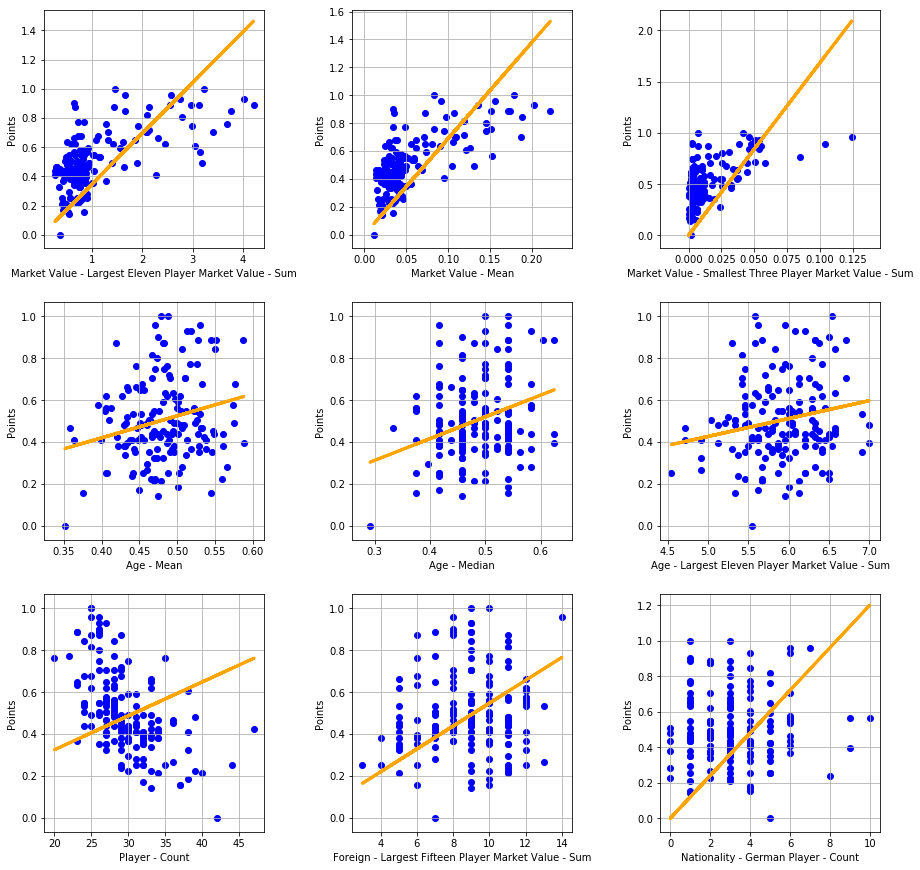

In [11]:
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interact, interactive, fixed
from sklearn.model_selection import train_test_split

merged_frame = construct_train()

plt.close('all')

i = 1

for first_level, second_level in merged_frame.columns:
    if first_level == 'Points': continue
    concat_string = first_level + ' - ' + second_level
    plot(merged_frame[first_level][second_level], merged_frame['Points'], concat_string, i)
    i += 1  

plt.gca().yaxis.set_minor_formatter(NullFormatter())
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.45, wspace=0.55)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=2.0)

plt.show()

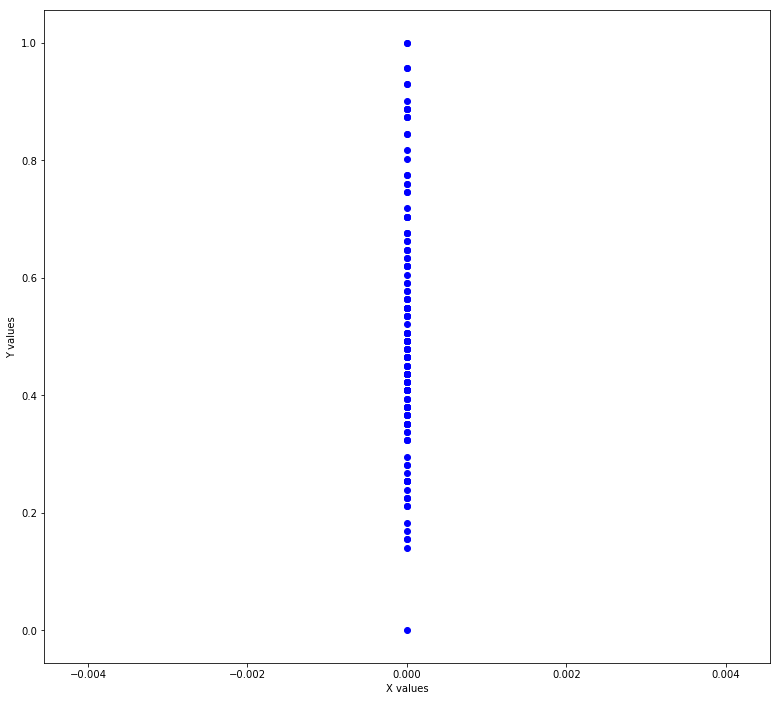

In [14]:
from mpl_toolkits.mplot3d import Axes3D
import statsmodels.formula.api as smf
from ipywidgets import interact, interactive, fixed

merged_frame = construct_train()

def plot_fit(w9, w8, w7, w6, w5, w4, w3, w2, w1):
    x = w9 * merged_frame['Age']['Mean']
    x += w8 * merged_frame['Age']['Median'] 
    x += w7 * merged_frame['Age']['Largest Eleven Player Market Value - Sum']
    x += w6 * merged_frame['Market Value']['Mean']
    x += w5 * merged_frame['Market Value']['Largest Eleven Player Market Value - Sum'] 
    x += w4 * merged_frame['Market Value']['Smallest Three Player Market Value - Sum']
    x += w3 * merged_frame['Player']['Count']
    x += w2 * merged_frame['Foreign']['Largest Fifteen Player Market Value - Sum'] 
    x += w1 * merged_frame['Nationality']['German Player - Count']
    y = merged_frame['Points']
    # Plot predictions and test data
    plt.scatter(x, y, color='blue')  # For test data
    plt.xlabel('X values')
    plt.ylabel('Y values')
    plt.show()

interact(plot_fit, w9=(-10, 10, 0.01), w8=(-10, 10, 0.01), w7=(-10, 10, 0.01), w6=(-10, 10, 0.01), w5=(-10, 10, 0.01), w4=(-10, 10, 0.01), w3=(-10, 10, 0.01), w2=(-10, 10, 0.01), w1=(-10, 10, 0.01));

C:\Users\rizao\Anaconda3\lib\site-packages\pandas\core\groupby.py:4281: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)
C:\Users\rizao\Anaconda3\lib\site-packages\pandas\core\generic.py:2530: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


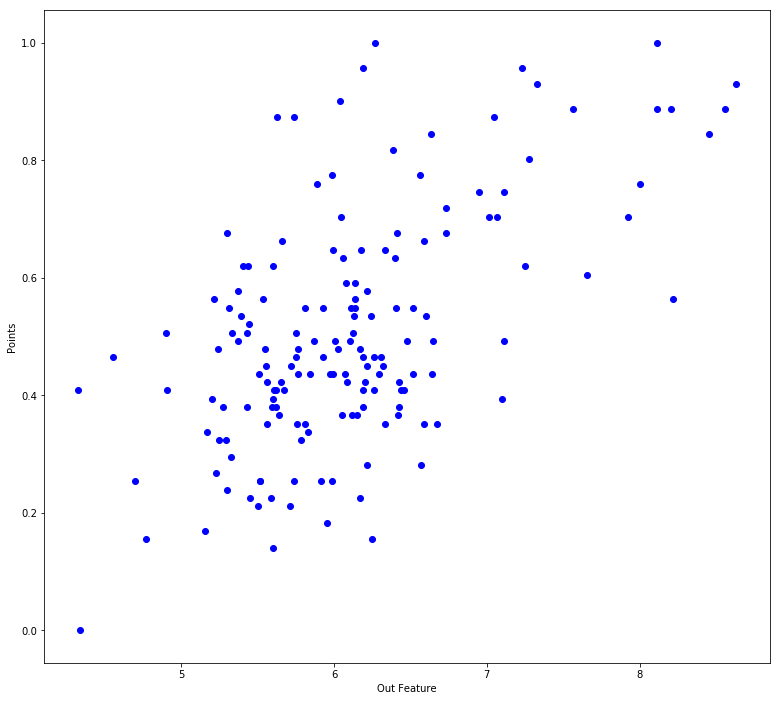

In [13]:
merged_frame = construct_train()
merged_frame.dropna(inplace=True)

y_train = merged_frame['Points']
X_train = merged_frame.drop('Points',axis=1).copy()

final_model = LinearRegression(fit_intercept=False)
final_model.fit(X_train,y_train)
model_1_features = [
    'Age - Mean', 
    'Age - Median', 
    'Age - Largest Eleven Player Market Value - Sum', 
    'Market Value - Largest Eleven Player Market Value - Sum',
    'Market Value - Mean',
    'Market Value - Smallest Three Player Market Value - Sum',
    'Player - Count',
    'Foreign - Largest Fifteen Player Market Value - Sum',
    'Nationality - German Player - Count',
]
coef_dict = {}
for coef, feat in zip(final_model.coef_,model_1_features):
    coef_dict[feat] = coef
    
    
x = coef_dict['Age - Mean'] * merged_frame['Age']['Mean']
x += coef_dict['Age - Median'] * merged_frame['Age']['Median'] 
x += coef_dict['Age - Largest Eleven Player Market Value - Sum'] * merged_frame['Age']['Largest Eleven Player Market Value - Sum']
x += coef_dict['Market Value - Largest Eleven Player Market Value - Sum'] * merged_frame['Market Value']['Largest Eleven Player Market Value - Sum']
x += coef_dict['Market Value - Mean'] * merged_frame['Market Value']['Mean']
x += coef_dict['Market Value - Smallest Three Player Market Value - Sum'] * merged_frame['Market Value']['Smallest Three Player Market Value - Sum']
x += coef_dict['Player - Count'] * merged_frame['Player']['Count']
x += coef_dict['Foreign - Largest Fifteen Player Market Value - Sum'] * merged_frame['Foreign']['Largest Fifteen Player Market Value - Sum'] 
x += coef_dict['Nationality - German Player - Count'] * merged_frame['Nationality']['German Player - Count']
predictions = final_model.predict(X_train)

# Plot predictions and test data
plt.scatter(x, y_train, color='blue')  # For train data
plt.xlabel('Out Feature')
plt.ylabel('Points')
plt.show()